In [105]:
%load_ext autoreload
%autoreload 2
import sys
from os import path
import os


sys.path.insert(0, "../")
sys.path.insert(0, "./")

from isanet.neural_network import MLPRegressor
from isanet.model import Mlp
from isanet.optimizer import SGD
from isanet.utils.model_utils import printMSE, printAcc, plotMse, save_data, load_data
from isanet.optimizer import EarlyStopping
from isanet.model_selection import Kfold, GridSearchCV

import numpy as np
import time
import datetime
import pickle
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# test high level API

In [104]:
%load_ext autoreload
%autoreload 2
dataset = np.genfromtxt('../CUP/ML-CUP19-TR_tr_vl.csv',delimiter=',')
X_train = dataset[:1000,:-2]
Y_train = dataset[:1000,-2:]
    
X_val = dataset[1000:,:-2]
Y_val = dataset[1000:,-2:]

param = {
            "n_layer_units": [38], # con questo si specifica la topologia da provare
            "learning_rate": 0.014,
            "momentum": 0.8,
            "nesterov": True,
            "kernel_regularizer": 0.0001,
            "activation": "sigmoid",
            "early_stop": EarlyStopping(0.00009, 20),
            "max_epoch": 100
}
model = MLPRegressor(X_train.shape[1], Y_train.shape[1], random_state = 42, verbose = 0, **param)
print(model.get_params())
model.fit(X_train, Y_train, X_val, Y_val)
model.get_history()["val_loss_mse"][-1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'n_layer_units': [38], 'activation': 'sigmoid', 'kernel_regularizer': 0.0001, 'batch_size': None, 'max_epoch': 100, 'learning_rate': 0.014, 'momentum': 0.8, 'nesterov': True, 'early_stop': eps: 9e-05, patience: 20}


2.170633367760731

# Test Kfold class

## - generate k-fold

In [36]:
dataset = np.genfromtxt('../CUP/ML-CUP19-TR_tr_vl.csv',delimiter=',')
X = dataset[:,:-2]
Y = dataset[:,-2:]
print(X.shape)
kf = Kfold(n_splits=5, shuffle=True, random_state=1)
print(kf.get_n_splits())
split = kf.split(X)

(1352, 20)
5


In [ ]:
print(split)

In [52]:
print(len(split["train"][0]))
print(len(split["val"][0]))

1082
270


## save and load k-folds

In [57]:
split = load_data("../CUP/4folds.index")

# test grid search

In [196]:
def test(grid):
    for p in grid:
        # Always sort the keys of a dictionary, for reproducibility
        items = sorted(p.items())
        if not items:
           yield {}
        else:
            keys, values = zip(*items)
            for v in product(*values):
                params = dict(zip(keys, v))
                yield params

def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))

grid = {
            "n_units": [(10, 20), (101, 201), (1,)], # con questo si specifica la topologia da provare
            "learning_rate": [0.014, 0.017, 0.020],
            "momentum": [0.8],
            "nesterov": [False, True],
            "kernel_regularizer": [0.0001, 0.0002, 0.0003],
            "activation": ["sigmoid", "relu"],
            "early_stop": [es]
}

default_grid = {
            "n_units": [100], # con questo si specifica la topologia da provare
            "activation": ["relu"],
            "kernel_regularizer": [0.0001],

            "batch_size": [None],
            "max_epoch": [1000],
            "learning_rate": [0.014, 0.017, 0.020],
            "momentum": [0.8],
            "nesterov": [False, True],
            "early_stop": [es]
}

print(len(list(product_dict(**grid))))
default_grid.update(grid)
print(default_grid[0])

108


KeyError: 0

In [148]:
%load_ext autoreload
%autoreload 2

dataset = np.genfromtxt('../CUP/ML-CUP19-TR_tr_vl.csv',delimiter=',')
split = load_data("../CUP/4folds.index")
X_train = dataset[:,:-2]
Y_train = dataset[:,-2:]

es = EarlyStopping(0.00009, 20)


mlp_r = MLPRegressor(X_train.shape[1], Y_train.shape[1])

grid0 = {
            "n_layer_units": [[120], [230]], # con questo si specifica la topologia da provare
            "learning_rate": [0.026, 0.029],
            "max_epoch": [13000],
            "momentum": [0.7,  0.8],
            "nesterov": [True],
            "kernel_regularizer": [0.0001, 0.0004],
            "activation": ["sigmoid"],
            "early_stop": [es],
}

grid1 = {
            "n_layer_units": [[120]], # con questo si specifica la topologia da provare
            "learning_rate": [0.00026],
            "max_epoch": [13000],
            "momentum": [0.7],
            "nesterov": [True],
            "kernel_regularizer": [0.0001],
            "activation": ["relu"],
            "early_stop": [es],
}

grid2 = {
            "n_layer_units": [[38]], # con questo si specifica la topologia da provare
            "learning_rate": [0.014, 0.017],
            "max_epoch": [13000],
            "momentum": [0.8],
            "nesterov": [True],
            "kernel_regularizer": [0.0001],
            "activation": ["sigmoid"],
            "early_stop": [es],
}
gs = GridSearchCV(estimator=mlp_r, param_grid = grid1, cv = split, verbose=2)
result = gs.fit(X, Y)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Total Grid Search Iteration: 1, Total train: 4
Start Grid Combination n. 1:
fold: 1/4 - TR MSE: 1.7742 - VL MSE: 1.8391 - Time: 0:01:07.621529
fold: 2/4 - TR MSE: 1.7601 - VL MSE: 2.0898 - Time: 0:01:02.396495


KeyboardInterrupt: 

In [125]:
import pandas as pd
df = pd.DataFrame(result)
df

,hyper_param,fold_results,mean_train_mse,std_train_mse,mean_train_mee,std_train_mee,mean_train_acc,std_train_acc,mean_val_mse,std_val_mse,mean_val_mee,std_val_mee,mean_val_acc,std_val_acc,time_train
0,"{'n_layer_units': [120], 'learning_rate': 0.02...","{'train_mse': [0.5613512871135166, 0.703505986...",0.591431,0.066309,0.853634,0.04083,0.0,0.0,1.021394,0.087621,1.112092,0.042161,0.0,0.0,363.121159


In [130]:
pd.DataFrame(df["fold_results"][0])

,train_mse,train_mee,train_acc,val_mse,val_mee,val_acc,init_weigth,final_weigth,fold_time
0,0.561351,0.829191,0.0,1.029656,1.106946,0.0,"[[[-0.031221833168017993, -0.10759847373236685...","[[[1.622004934017362, -0.6911691621642565, -0....",124.927676
1,0.703506,0.923510,0.0,1.140926,1.177466,0.0,"[[[0.18678834030076547, -0.18352462390604052, ...","[[[-0.3911264134386995, -0.9064238538968712, 0...",51.745208
2,0.569934,0.839759,0.0,0.893512,1.059661,0.0,"[[[0.011053931864456579, -0.04102103884800304,...","[[[-0.7443862280740351, -1.1273987081367312, 4...",80.156019
3,0.530933,0.822077,0.0,1.021481,1.104296,0.0,"[[[0.18628015854293406, -0.11387125121236806, ...","[[[-0.3497201536446918, 0.35647190238197224, 0...",106.241446


In [151]:
kfold = load_data("../CUP/4folds.index")
n_unit = df["hyper_param"][0]["n_layer_units"][0]
lr = df["hyper_param"][0]["learning_rate"]
momentum = df["hyper_param"][0]["momentum"]/2
reg = df["hyper_param"][0]["kernel_regularizer"]
for train_index_fold, val_index_fold, w in zip(kfold["train"], kfold["val"], df["fold_results"][0]["init_weigth"]):
                    
    X_train = dataset[train_index_fold,:-2]
    Y_train = dataset[train_index_fold,-2:]

    X_val = dataset[val_index_fold,:-2]
    Y_val = dataset[val_index_fold,-2:]
    
    num_unit = n_unit
    kernel_regularizer = reg
    model = Mlp()
    model.add(num_unit, activation="sigmoid", input= 20, kernel_initializer = np.sqrt(6)/np.sqrt(num_unit + 20), kernel_regularizer = kernel_regularizer)
    model.add(2, activation="linear", kernel_initializer = np.sqrt(6)/np.sqrt(2 + num_unit), kernel_regularizer = kernel_regularizer)


    model.set_optimizer(
        SGD(
            lr = lr,
            momentum = momentum,
            nesterov = False
        )
    )
    model.weights = w
    es = EarlyStopping(0.00009, 20)

    start_time = time.time()
    model.fit(X_train,
                Y_train, 
                epochs=13000, 
                validation_data = [X_val, Y_val],
                es = es,
                verbose=0) 

    out = model.predict(X_train)
    delta = Y_train - out
    mean_tr_mse.append(np.mean(np.square(delta)))

    outputNet = model.predict(X_val)
    delta = Y_val - outputNet
    mean_vl_mse.append(np.mean(np.square(delta)))

    outputNet = model.predict(X_val)

    out = model.predict(X_train)
    delta = Y_train - out
    mean_tr_mse.append(np.mean(np.square(delta)))

    outputNet = model.predict(X_val)
    delta = Y_val - outputNet
    mean_vl_mse.append(np.mean(np.square(delta)))

print("training: {}+/-{}".format(np.mean(mean_tr_mse), np.std(mean_tr_mse)))
print("validation: {}+/-{}".format(np.mean(mean_vl_mse), np.std(mean_vl_mse)))

training: 1.7558383237405353+/-1.1612630049796557
validation: 1.969284101474181+/-1.0290576778489717


In [357]:
pd.DataFrame(df["fold_results"][1])

,train_mse,train_mee,train_acc,val_mse,val_mee,val_acc,init_weigth,final_weigth,fold_time
0,0.730083,0.947299,0.0,1.038045,1.106975,0.0,"[[[-0.10998516269158107, -0.03474271985218419,...","[[[-0.01643337689075059, -1.2148934603607338, ...",17.389263
1,0.638482,0.889918,0.0,1.205173,1.177304,0.0,"[[[-0.20230808635709352, 0.16757201479997574, ...","[[[1.3820625334936396, -0.4969471144614831, 1....",27.567935
2,0.668010,0.911347,0.0,1.005068,1.141300,0.0,"[[[0.31195745997992474, 0.07908460639642173, 0...","[[[-1.126429472053428, 1.3162840171884789, -0....",52.022505
3,0.707622,0.935678,0.0,0.911923,1.037854,0.0,"[[[-0.14037858468976755, -0.09049152675502253,...","[[[-0.11832453694566324, 2.4419481243146293, -...",26.730980
4,0.896949,1.052838,0.0,1.093168,1.149470,0.0,"[[[-0.3027322108995666, 0.16416642582688795, 0...","[[[-1.7961261592281033, -0.6740503420552622, -...",5.333829


# Some test on k-folds cup datatest

In [2]:
TS = np.genfromtxt('../CUP/ML-CUP19-TR_tr_vl.csv',delimiter=',')
kfold = load_kfold("../CUP/4folds.index")

In [ ]:
for train_index_fold, val_index_fold in zip(kfold["train"], kfold["val"]):
    X_train = TS[train_index_fold,:-2]
    Y_train = TS[train_index_fold,-2:]
    
    X_val = TS[val_index_fold,:-2]
    Y_val = TS[val_index_fold,-2:]

    model = Mlp()
    model.add(43, activation="sigmoid", input= 20, kernel_initializer = 0.001, kernel_regularizer = 0.001)
    model.add(2, activation="linear", kernel_initializer = 0.001, kernel_regularizer = 0.0001)

    model.set_optimizer(
        SGD(
            lr = 0.019,
            momentum = 0.8,
            nesterov = True
        ))
    # Batch
    start_time = time.time()
    model.fit(X_train,
                Y_train, 
                epochs=10000, 
                #batch_size=31,
                validation_data = [X_val, Y_val],
                verbose=0) 

    outputNet = model.predict(X_val)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    print(model.history["loss_mse"][-1])
    print(model.history["val_loss_mse"][-1])    

In [ ]:
n_units = list(range(35, 45+1)) 
lrs = list(np.arange(0.017, 0.021, 0.0004))
momentus = list(np.arange(0.6, 0.9, 0.04))
parameters = []
means = []
devs = []

time_means = []
total_grid_search_iteration = len(n_units)*len(lrs)*len(momentus)
print("Total Grid Search Iteration: {}".format(total_grid_search_iteration))
estimated_time = (total_grid_search_iteration*4*45)/(60*60)
print("Estimated time {}h".format(estimated_time))
i = 0
for units in n_units:
    for lr in lrs:
        for momentum in momentus:
            parameters.append([units, lr, momentum])
            mean = []
            start_time = time.time()
            for train_index_fold, val_index_fold in zip(kfold["train"], kfold["val"]):
                X_train = TS[train_index_fold,:-2]
                Y_train = TS[train_index_fold,-2:]

                X_val = TS[val_index_fold,:-2]
                Y_val = TS[val_index_fold,-2:]

                model = Mlp()
                model.add(units, activation="sigmoid", input= 20, kernel_initializer = 1/np.sqrt(20), kernel_regularizer = 0.001)
                model.add(2, activation="linear", kernel_initializer = 1/np.sqrt(20), kernel_regularizer = 0.0001)

                model.set_optimizer(
                    SGD(
                        lr = lr,
                        momentum = momentum,
                        nesterov = True
                    ))
                # Batch
                start_time = time.time()
                model.fit(X_train,
                            Y_train, 
                            epochs=10, 
                            #batch_size=31,
                            validation_data = [X_val, Y_val],
                            verbose=0) 

                mean.append(model.history["val_loss_mse"][-1])
            means.append(np.mean(mean))
            devs.append(np.std(mean))
            i+=1
            time_means.append((time.time() - start_time))
            remaining_time = (np.mean(time_means)*(total_grid_search_iteration-i))
            print("It: {}/{} - mean: {} - std:{} | Remaining time: {}".format(i,total_grid_search_iteration,means[-1],devs[-1],datetime.timedelta(seconds=remaining_time)))

save_data(parameters, 'parameters.data')
save_data(means, 'means.data')
save_data(devs, 'devs.data')

Epoch: 1 - time: 0.0030 - loss_train: 155.4272188781142 - loss_val: 169.02272613503783
Epoch: 2 - time: 0.0029 - loss_train: 58.059295461282666 - loss_val: 62.95695722104831
Epoch: 3 - time: 0.0028 - loss_train: 23.103755227179455 - loss_val: 21.632791794947117
Epoch: 4 - time: 0.0026 - loss_train: 76.93822825675481 - loss_val: 83.65676528526961
Epoch: 5 - time: 0.0027 - loss_train: 78.53423232672654 - loss_val: 85.26045723506255
Epoch: 6 - time: 0.0026 - loss_train: 25.974274657915313 - loss_val: 24.813131633462596
Epoch: 7 - time: 0.0028 - loss_train: 17.629982625369564 - loss_val: 16.580521039930304
Epoch: 8 - time: 0.0027 - loss_train: 21.514947793649494 - loss_val: 22.740603379402085
Epoch: 9 - time: 0.0027 - loss_train: 25.526903358379997 - loss_val: 27.6447311228572
Epoch: 10 - time: 0.0027 - loss_train: 24.885959713907003 - loss_val: 26.618985379486787
Epoch: 11 - time: 0.0028 - loss_train: 20.16708639399942 - loss_val: 21.255373158574038
Epoch: 12 - time: 0.0028 - loss_train: 

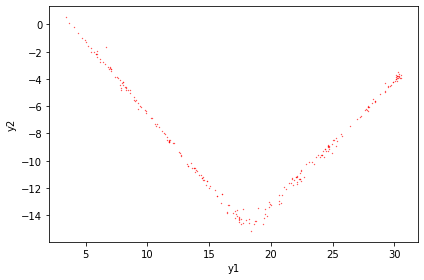

Loss test: 0.8908143721445426 


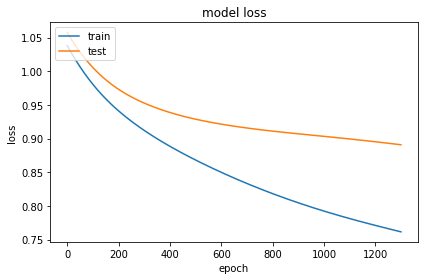

In [41]:
X_train = TS[:1000,:-2]
Y_train = TS[:1000,-2:]
    
X_val = TS[1000:1250,:-2]
Y_val = TS[1000:1250,-2:]

model = Mlp()
model.add(38, activation="sigmoid", input= 20, kernel_initializer = 1/np.sqrt(20), kernel_regularizer = 0.0001)
model.add(2, activation="linear", kernel_initializer = 1/np.sqrt(100), kernel_regularizer = 0.0001)

model.set_optimizer(
    SGD(
        lr = 0.018200000000000004,
        momentum = 0.8800000000000002,
        nesterov = True
    ))

start_time = time.time()
model.fit(X_train,
            Y_train, 
            epochs=1800, 
            validation_data = [X_val, Y_val],
            verbose=1) 

print("--- %s seconds ---" % (time.time() - start_time))
outputNet = model.predict(X_val)

plt.plot(outputNet[:,-2], outputNet[:,-1], 'ro', markersize=0.3)
plt.ylabel('y2')
plt.xlabel('y1')
plt.tight_layout()
plt.show()

printMSE(outputNet, Y_val, type = "test")
plt.plot(model.history["loss_mse"][500:])
plt.plot(model.history["val_loss_mse"][500:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()


In [19]:
X_train = TS[:1000,:-2]
Y_train = TS[:1000,-2:]
    
X_val = TS[1000:1250,:-2]
Y_val = TS[1000:1250,-2:]

model = Mlp()
units = 56
model.add(units, activation="sigmoid", input= 20, kernel_initializer = np.sqrt(6)/np.sqrt(20+units), kernel_regularizer = 0.0007108)
model.add(2, activation="linear", kernel_initializer = np.sqrt(6)/np.sqrt(units+2), kernel_regularizer = 0.000108)

model.set_optimizer(
    SGD(
        lr = 0.018200000000000004,
        momentum = 0.8800000000000002,
        nesterov = True
    ))

start_time = time.time()
model.fit(X_train,
            Y_train, 
            epochs=18000, 
            validation_data = [X_val, Y_val],
            verbose=1) 

print("--- %s seconds ---" % (time.time() - start_time))
outputNet = model.predict(X_val)

plt.plot(outputNet[:,-2], outputNet[:,-1], 'ro', markersize=0.3)
plt.ylabel('y2')
plt.xlabel('y1')
plt.tight_layout()
plt.show()

printMSE(outputNet, Y_val, type = "test")
plt.plot(model.history["loss_mse"][500:])
plt.plot(model.history["val_loss_mse"][500:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

Epoch: 1 - time: 0.0042 - loss_train: 127.08884659634317 - loss_val: 138.04436597344215
Epoch: 2 - time: 0.0041 - loss_train: 29.04561518992258 - loss_val: 29.322501535259413
Epoch: 3 - time: 0.0046 - loss_train: 53.143890449166456 - loss_val: 52.697868034017546
Epoch: 4 - time: 0.0039 - loss_train: 95.33546871630836 - loss_val: 101.80419623993272
Epoch: 5 - time: 0.0039 - loss_train: 43.83840259214797 - loss_val: 45.79714318328057
Epoch: 6 - time: 0.0039 - loss_train: 10.259225317266738 - loss_val: 9.829743138161987
Epoch: 7 - time: 0.0039 - loss_train: 23.165933237519894 - loss_val: 25.177885842383574
Epoch: 8 - time: 0.0039 - loss_train: 38.91660456971095 - loss_val: 42.541713090670555
Epoch: 9 - time: 0.0039 - loss_train: 35.87347048869118 - loss_val: 38.958342815704356
Epoch: 10 - time: 0.0039 - loss_train: 19.87757057840891 - loss_val: 21.426754500328848
Epoch: 11 - time: 0.0042 - loss_train: 9.232452620587031 - loss_val: 9.76774690939649
Epoch: 12 - time: 0.0039 - loss_train: 12

KeyboardInterrupt: 

In [ ]:
for train_index_fold, val_index_fold in zip(kfold["train"], kfold["val"]):
    X_train = TS[train_index_fold,:-2]
    Y_train = TS[train_index_fold,-2:]
    
    X_val = TS[val_index_fold,:-2]
    Y_val = TS[val_index_fold,-2:]

    model = Mlp()
    model.add(38, activation="relu", input= 20, kernel_initializer = np.sqrt(6)/np.sqrt(20+62), kernel_regularizer = 0)
    model.add(2, activation="linear", kernel_initializer = np.sqrt(6)/np.sqrt(62+2), kernel_regularizer = 0)

    model.set_optimizer(
        SGD(
            lr = 0.00018200000000000004,
            momentum = 0.8800000000000002,
            nesterov = True
        ))

    start_time = time.time()
    model.fit(X_train,
                Y_train, 
                epochs=6000, 
                validation_data = [X_val, Y_val],
                verbose=1) 

    print("--- %s seconds ---" % (time.time() - start_time))
    print(model.history["loss_mse"][-1])
    print(model.history["val_loss_mse"][-1])    

# test with ealry stopping

Epoch: 1 - time: 0.0623 - loss_train: 134.09876838306036 - loss_val: 145.97654379762196
Epoch: 2 - time: 0.0042 - loss_train: 36.033331667180214 - loss_val: 36.97240748090518
Epoch: 3 - time: 0.0070 - loss_train: 50.23105476569823 - loss_val: 49.33762717678182
Epoch: 4 - time: 0.0044 - loss_train: 97.6142077423665 - loss_val: 106.10891571103033
Epoch: 5 - time: 0.0040 - loss_train: 45.623602132894895 - loss_val: 48.63455549724785
Epoch: 6 - time: 0.0043 - loss_train: 11.630462267039297 - loss_val: 11.281772449134184
Epoch: 7 - time: 0.0039 - loss_train: 26.112191369783336 - loss_val: 28.393422986355247
Epoch: 8 - time: 0.0045 - loss_train: 39.27209240495549 - loss_val: 42.882683224697494
Epoch: 9 - time: 0.0039 - loss_train: 35.67434818479178 - loss_val: 38.40378859813673
Epoch: 10 - time: 0.0047 - loss_train: 21.21889947159912 - loss_val: 22.363315854851592
Epoch: 11 - time: 0.0038 - loss_train: 11.512395377667277 - loss_val: 12.039895031732385
Epoch: 12 - time: 0.0038 - loss_train: 1

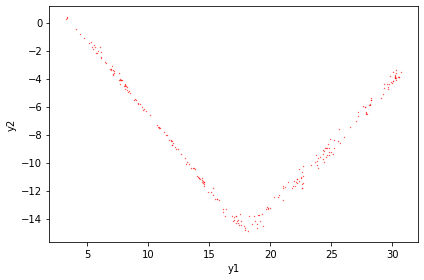

Loss test: 0.9226661772285841 


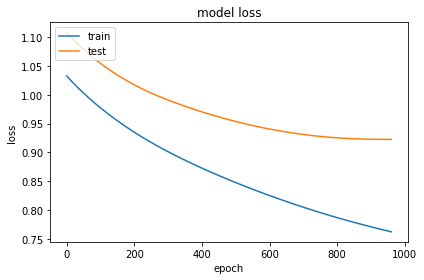

In [13]:
X_train = TS[:1000,:-2]
Y_train = TS[:1000,-2:]
    
X_val = TS[1000:1250,:-2]
Y_val = TS[1000:1250,-2:]

model = Mlp()
model.add(52, activation="sigmoid", input= 20, kernel_initializer = 1/np.sqrt(20), kernel_regularizer = 0.0001)
model.add(2, activation="linear", kernel_initializer = 1/np.sqrt(100), kernel_regularizer = 0.0001)

model.set_optimizer(
    SGD(
        lr = 0.018200000000000004,
        momentum = 0.8800000000000002,
        nesterov = True
    ))

start_time = time.time()
model.fit(X_train,
            Y_train, 
            epochs=10000, 
            validation_data = [X_val, Y_val],
            es = 0.0001,
            verbose=1) 

print("--- %s seconds ---" % (time.time() - start_time))
outputNet = model.predict(X_val)

plt.plot(outputNet[:,-2], outputNet[:,-1], 'ro', markersize=0.3)
plt.ylabel('y2')
plt.xlabel('y1')
plt.tight_layout()
plt.show()

printMSE(outputNet, Y_val, type = "test")
plt.plot(model.history["loss_mse"][500:])
plt.plot(model.history["val_loss_mse"][500:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

